## 0. 라이브러리

In [1]:
import os
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import json
from soynlp.normalizer import *
from tqdm import tqdm
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 1. 데이터 불러오기

In [2]:
train_data_path ="~/aiffel/dktc/data2/train0.csv"
train_data = pd.read_csv(train_data_path,index_col=0)
train_data

,class,conversation
idx,,
1,기타 괴롭힘 대화,저기요 사장님\n네 무슨일인가요?\n제가 여기서 짜장면을 사갔는데.상태가 안좋네요....
2,협박 대화,어꺠를 쳤으면 사과를 해야지.\n세상이 말세다. 말세야 너가 뭔데 사과를 해라마라야...
3,협박 대화,이새끼야 내돈가지고와\n한번만 봐주세요 .다음주까지가지고올게요\n됏고 이새끼야 야!...
4,일반 대화,정촌은 버스가 늘어야 행\n너무 불편함\n버스 노선 너무 길어 ㅠㅠ\n버스가 넘 없...
5,직장 내 괴롭힘 대화,박과장 일로와바\n네 부르셨습니까\n요즘 이대리 일을 하는거야 마는거야\n그게 무슨...
...,...,...
4826,기타 괴롭힘 대화,저기 이 제품 좀 꺼내서 볼 수 있나요?\n네? 어떤 제품 말씀하세요 고객님?\n여...
4827,기타 괴롭힘 대화,우리 귀여운 철수야 여기 돈 줄테니까 핫도그랑 콜라좀 사다줄래? 남은 돈은 너 가져...
4828,협박 대화,후보직 사퇴해\n무슨뜬금없는소리야\n니 가정 파탄나기싫으면 사퇴하라고\n내가 이런 ...


## 2. 데이터 준비 (Data preparation)
### 2.1-1 전처리 함수 정의

In [3]:
def preprocess_sentence(sentence):
    sentence = re.sub(r'([^a-zA-Zㄱ-ㅎ가-힣?.!,])', " ", sentence)
    sentence = re.sub(r'!+', '!', sentence)
    sentence = re.sub(r'\?+', '?', sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

### 2.1-2 전처리 함수 적용

In [4]:
# 학습할 문장이 담길 배열
sentences = []

for val in tqdm(train_data['conversation']):
    sentences.append(preprocess_sentence(val))

100%|██████████| 4830/4830 [00:00<00:00, 14998.62it/s]


### 2.2 최대 길이 지정

In [5]:
MAX_LEN = 300

### 2.3 class(label) 인코딩

In [6]:
from sklearn.preprocessing import LabelEncoder

CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화','일반 대화']

encoder = LabelEncoder()
encoder.fit(CLASS_NAMES)

train_data['class'] = encoder.transform(train_data['class'])
labels = train_data['class']

len(labels)

4830

In [7]:
class_mapping = {class_name: encoder.transform([class_name])[0] for class_name in CLASS_NAMES}
print("Class mapping:", class_mapping)

Class mapping: {'협박 대화': 4, '갈취 대화': 0, '직장 내 괴롭힘 대화': 3, '기타 괴롭힘 대화': 1, '일반 대화': 2}


### 2.4 train-val

In [8]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    sentences, labels, test_size=0.2, random_state=42)

## 3. 모델
### 3.1-1 토크나이저 정의

In [9]:
# BERT 토크나이저와 모델 준비
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

### 3.1-2 토크나이저 적용

In [10]:
# 데이터셋을 BERT 입력 형식으로 변환
train_encodings = tokenizer(train_sentences, truncation=True, padding=True, max_length=MAX_LEN) # 뒤쪽에 패딩
val_encodings = tokenizer(val_sentences, truncation=True, padding=True, max_length=MAX_LEN)

### 3.2 모델 준비

In [11]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=5)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 3.3 파라미터

In [12]:
BATCH_SIZE = 16
lr = 5e-5
EPOCH = 10

### 3.4 TF 데이터셋 생성

In [13]:
# TensorFlow 데이터셋 생성
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(100).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(BATCH_SIZE)


### 3.5 모델 컴파일

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 3.6 모델 훈련

### 3.6-1 콜백 설정

In [15]:
early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=2,            
    restore_best_weights=True  
)

checkpoint = ModelCheckpoint(
    filepath='best_model_weights.h5',  
    monitor='val_loss',        
    save_best_only=True,       
    save_weights_only=True,   
    mode='min',             
    verbose=1                 
)

### 3.6-2 모델 훈련

In [16]:
history = model.fit(
    train_dataset, 
    validation_data=val_dataset,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
242/242 [==============================] - 288s 1s/step - loss: 0.8302 - accuracy: 0.6949 - val_loss: 0.6340 - val_accuracy: 0.7723

Epoch 00001: val_loss improved from inf to 0.63398, saving model to best_model_weights.h5
Epoch 2/10
242/242 [==============================] - 275s 1s/step - loss: 0.6166 - accuracy: 0.7909 - val_loss: 0.5978 - val_accuracy: 0.7950

Epoch 00002: val_loss improved from 0.63398 to 0.59776, saving model to best_model_weights.h5
Epoch 3/10
242/242 [==============================] - 275s 1s/step - loss: 0.4422 - accuracy: 0.8489 - val_loss: 0.4453 - val_accuracy: 0.8447

Epoch 00003: val_loss improved from 0.59776 to 0.44534, saving model to best_model_weights.h5
Epoch 4/10
242/242 [==============================] - 276s 1s/step - loss: 0.3282 - accuracy: 0.8882 - val_loss: 0.5909 - val_accuracy: 0.8333

Epoch 00004: val_loss did not improve from 0.44534
Epoch 5/10
242/242 [==============================] - 275s 1s/step - loss: 0.2656 - accuracy: 0

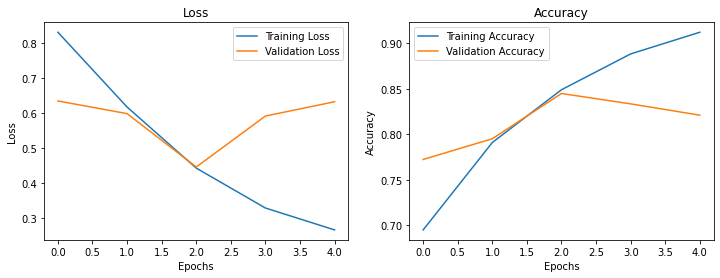

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 3.7 모델 평가

In [18]:
# 모델 평가
evaluation = model.evaluate(val_dataset)
print("평가 결과:", evaluation)

61/61 [==============================] - 21s 346ms/step - loss: 0.4453 - accuracy: 0.8447
평가 결과: [0.44534143805503845, 0.8447204828262329]


In [24]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np

X, y = [], []
for batch in val_dataset:
    inputs, labels = batch
    X.append(inputs)
    y.append(labels)
# 각 입력 키에 대해 데이터를 결합하여 numpy 배열로 변환
X = {key: np.concatenate([d[key].numpy() for d in X], axis=0) for key in X[0].keys()}
y = np.concatenate(y, axis=0)
    
# 실제 예측값 생성
real_predictions = model.predict(X)
logits = real_predictions.logits

# 예측값을 레이블로 변환
if logits.ndim > 1:
        real_predicted_labels = np.argmax(logits, axis=1)
else:
        real_predicted_labels = (logits > 0.5).astype(int)
    

# 정확도 계산
real_accuracy = accuracy_score(y, real_predicted_labels)
print(f"Real Accuracy: {real_accuracy:.4f}")

# 분류 보고서 생성
real_report = classification_report(y, real_predicted_labels, target_names=[f"Class {i}" for i in range(logits.shape[1])])
print(real_report)

# F1 스코어 계산
real_f1 = f1_score(y, real_predicted_labels, average='weighted')
print(f"\nWeighted F1 Score (based on real predictions): {real_f1:.4f}")

Real Accuracy: 0.8447
              precision    recall  f1-score   support

     Class 0       0.76      0.87      0.81       211
     Class 1       0.86      0.69      0.77       208
     Class 2       1.00      0.97      0.98       169
     Class 3       0.86      0.93      0.89       195
     Class 4       0.79      0.78      0.78       183

    accuracy                           0.84       966
   macro avg       0.85      0.85      0.85       966
weighted avg       0.85      0.84      0.84       966


Weighted F1 Score (based on real predictions): 0.8436


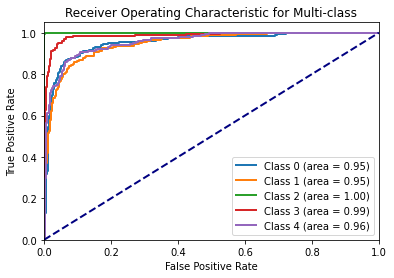

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize

real_predicted_probs = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
plt.figure()
y_bin = label_binarize(y, classes=[i for i in range(logits.shape[1])])
for i in range(logits.shape[1]):
    fpr, tpr, _ = roc_curve(y_bin[:, i], real_predicted_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-class')
plt.legend(loc="lower right")
plt.show()

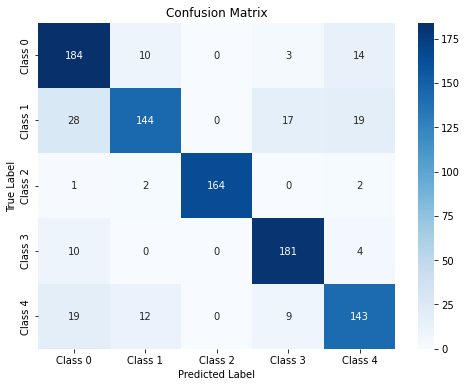

In [31]:
import seaborn as sns
conf_matrix = confusion_matrix(y, real_predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[f"Class {i}" for i in range(logits.shape[1])], yticklabels=[f"Class {i}" for i in range(logits.shape[1])])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 4. 모델 적용

In [ ]:
test_data_path ="/aiffel/aiffel/dktc/data/test.json"

with open(test_data_path, "r", encoding="utf-8") as json_file:
    test = json.load(json_file)

In [ ]:
import numpy as np

test_predicst = list()

for key in test:
    test_sentence = test[key]['text']
    
    test_encodings = tokenizer(test_sentence, truncation=True, padding=True, max_length=300, return_tensors="tf")
    
    test_predictions = model.predict({
        "input_ids": test_encodings["input_ids"],
        "token_type_ids": test_encodings["token_type_ids"],
        "attention_mask": test_encodings["attention_mask"]
    }) 
    test_class_probabilities = tf.nn.softmax(test_predictions.logits, axis=-1).numpy() 
    test_predicted_class = np.argmax(test_class_probabilities, axis=1) 
    test_predicst.append(test_predicted_class[0])

In [ ]:
test_predicst

In [ ]:
def labelnum_to_text(x):
    if x == 1 : # '기타 괴롭힘 대화'
        return '03'
    if x == 2 : # '일반 대화'
        return '04'
    if x == 3 : # '직장 내 괴롭힘 대화
        return '02'
    if x == 0 : # '갈취 대화' 
        return '01'
    if x == 4 : # '협박 대화'
        return "00"
    
submission = pd.DataFrame({'class':test_predicst}, index=list(test.keys()))
submission['class'] = submission['class'].apply(labelnum_to_text)
submission

In [ ]:
submission.to_csv('~/aiffel/dktc/data2/submission_base.csv')